In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, GlobalAveragePooling2D
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import seaborn as sns

In [2]:
data_dir = 'Dataset'
train_dir = 'split/train'
test_dir = 'split/test'
val_dir = 'split/val'

In [3]:
diseases_name = []
for image_class in os.listdir(train_dir):
    diseases_name.append(image_class)
print(diseases_name)
print(f'Total Disease: {len(diseases_name)}')

['Normal', 'Stroke']
Total Disease: 2


In [4]:
train_data = image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=42
)
test_data = image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=(224, 224),
    batch_size=32,
    shuffle=False,
    seed=42
)
val_data = image_dataset_from_directory(
    val_dir,
    label_mode="categorical",
    image_size=(224, 224),
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 2000 files belonging to 2 classes.
Found 251 files belonging to 2 classes.
Found 250 files belonging to 2 classes.


In [5]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6,
                                              min_delta=0.0001)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2,
                                                 patience=4, min_lr=1e-7)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')

In [6]:
n_class = len(diseases_name)

model = Sequential()

pretrained_model = ResNet50(include_top=False,
                            input_shape=(224, 224, 3),
                            pooling='max', classes=n_class,
                            weights='imagenet')
pretrained_model.trainable = False

pretrained_model = Model(
    inputs=pretrained_model.inputs,
    outputs=pretrained_model.layers[-2].output
)
model.add(pretrained_model)

model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())

model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(512, activation='relu'))

model.add(Dense(n_class, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 7, 7, 2048)        23587712  
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 2048)       8192      
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 dense_1 (Dense)             (None, 64)                2

In [7]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

In [8]:
hist = model.fit(train_data, epochs=50, validation_data=val_data,
                 callbacks=[
                    early_stop,
                 ])

Epoch 1/50
63/63 [==============================] - 30s 221ms/step - loss: 0.6246 - accuracy: 0.6500 - val_loss: 0.5633 - val_accuracy: 0.7040
Epoch 2/50
63/63 [==============================] - 11s 168ms/step - loss: 0.4764 - accuracy: 0.7805 - val_loss: 0.4222 - val_accuracy: 0.8080
Epoch 3/50
63/63 [==============================] - 11s 164ms/step - loss: 0.3266 - accuracy: 0.8555 - val_loss: 0.4390 - val_accuracy: 0.8080
Epoch 4/50
63/63 [==============================] - 11s 163ms/step - loss: 0.2175 - accuracy: 0.9095 - val_loss: 0.4307 - val_accuracy: 0.8520
Epoch 5/50
63/63 [==============================] - 10s 160ms/step - loss: 0.1892 - accuracy: 0.9265 - val_loss: 0.4778 - val_accuracy: 0.8480
Epoch 6/50
63/63 [==============================] - 11s 164ms/step - loss: 0.1379 - accuracy: 0.9490 - val_loss: 0.5497 - val_accuracy: 0.8240
Epoch 7/50
63/63 [==============================] - 12s 182ms/step - loss: 0.1272 - accuracy: 0.9545 - val_loss: 0.5592 - val_accuracy: 0.7840

In [9]:
model.save('saved_models/ResNet.h5')

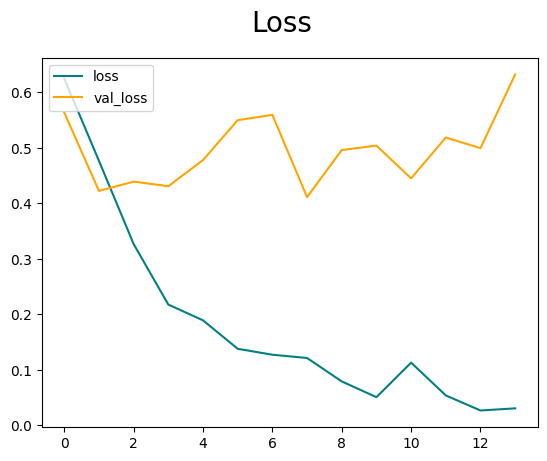

In [10]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

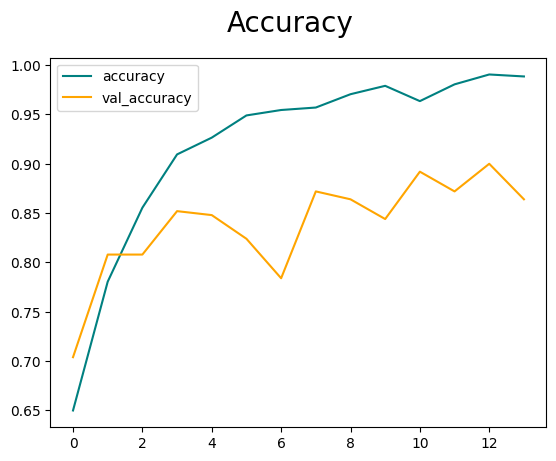

In [11]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [12]:
test_loss, test_acc = model.evaluate(test_data)
print(f'Test Loss: {test_loss} Test Accuracy: {test_acc}')

8/8 [==============================] - 3s 317ms/step - loss: 0.9235 - accuracy: 0.8327
Test Loss: 0.9234566688537598 Test Accuracy: 0.8326693177223206


In [13]:
y_pred = model.predict(test_data)

8/8 [==============================] - 3s 168ms/step


1/1 [==============================] - 2s 2s/step


<AxesSubplot: >

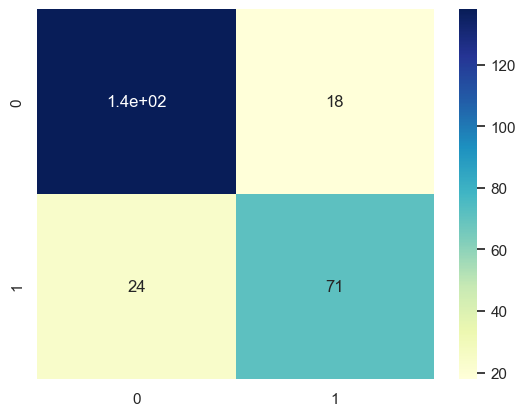

In [14]:
sns.set()
y_pred = []
for x, y in test_data:
    y_pred.extend(np.argmax(model.predict(x), axis=1).tolist())

y_true = []
for x, y in test_data:
    y_true.extend(np.argmax(y, axis=1).tolist())

conf_mat = confusion_matrix(y_true, y_pred)

sns.heatmap(conf_mat, annot=True, cmap="YlGnBu")

In [15]:
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)

print(f'precision: {np.average(precision)}')
print(f'Recall: {np.average(recall)}')

precision: 0.8248023304203079
Recall: 0.8159919028340081
